<a href="https://colab.research.google.com/github/prathyushalahari/AI-Bayesian-Network-Model/blob/main/UNet%26REFUGE2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
'''STEP-1 : IMPORT LIBRARIES'''
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint




In [3]:
'''STEP-2 : LOAD THE DATA'''
# Mount Google Drive
# from google.colab import drive
# drive.mount('/content/drive')
# Set the data paths
train_images_path = '/content/drive/MyDrive/REFUGE2/train/images'
train_masks_path = '/content/drive/MyDrive/REFUGE2/train/mask'


# Load images and masks
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename))
        img = cv2.resize(img, (256, 256))
        if img is not None:
            images.append(img)
    return np.array(images)

train_images = load_images_from_folder(train_images_path)
train_masks = load_images_from_folder(train_masks_path)

# Normalize images and masks
train_images = train_images / 255.0
train_masks = train_masks / 255.0

# Split into training and validation sets
#X_train, X_val, y_train, y_val = train_test_split(train_images, train_masks, test_size=0.2, random_state=42)

print(train_images.shape)
print(train_masks.shape)

(400, 256, 256, 3)
(400, 256, 256, 3)


In [4]:
# # Convert masks to grayscale (single-channel) if they are not already grayscale
# def preprocess_mask(mask):
#     if mask.shape[-1] == 3:  # Ensure the mask has 3 channels (RGB)
#         # Convert the mask to uint8 before applying cvtColor
#         mask = mask.astype(np.uint8)
#         return cv2.cvtColor(mask, cv2.COLOR_RGB2GRAY)
#     elif mask.shape[-1] == 1:  # If the mask is already grayscale, return as is
#         return mask.squeeze()  # Remove the extra dimension if present
#     else:
#         raise ValueError(f"Mask input has unexpected shape: {mask.shape}. Expected 3 channels (RGB) or 1 channel (grayscale).")

#         # Add a channel dimension if it's not present
#     if len(mask.shape) == 2:
#         mask = mask[..., np.newaxis]  # Add channel dimension

#     return mask


# # Convert train_masks to grayscale and expand dimensions to match model output
# train_masks_processed = np.array([preprocess_mask(mask) for mask in train_masks])
# # Reshape the masks to (num_masks, height, width, 1) if they aren't already
# train_masks_processed = train_masks_processed.reshape(train_masks_processed.shape[0], train_masks_processed.shape[1], train_masks_processed.shape[2], 1)

# # Now, train_masks will have shape (400, 256, 256, 1)

# # Update the original train_masks variable
# train_masks = train_masks_processed



In [5]:
'''Step 3: Define the U-Net Model'''
def unet_model(input_size=(256, 256, 3)):
    inputs = Input(input_size)

    # Contracting Path
    c1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, 3, activation='relu', padding='same')(c1)
    p1 = MaxPooling2D(pool_size=(2, 2))(c1)

    c2 = Conv2D(128, 3, activation='relu', padding='same')(p1)
    c2 = Conv2D(128, 3, activation='relu', padding='same')(c2)
    p2 = MaxPooling2D(pool_size=(2, 2))(c2)

    c3 = Conv2D(256, 3, activation='relu', padding='same')(p2)
    c3 = Conv2D(256, 3, activation='relu', padding='same')(c3)

    # Expanding Path
    u4 = UpSampling2D(size=(2, 2))(c3)
    u4 = concatenate([u4, c2])
    c4 = Conv2D(128, 3, activation='relu', padding='same')(u4)
    c4 = Conv2D(128, 3, activation='relu', padding='same')(c4)

    u5 = UpSampling2D(size=(2, 2))(c4)
    u5 = concatenate([u5, c1])
    c5 = Conv2D(64, 3, activation='relu', padding='same')(u5)
    c5 = Conv2D(64, 3, activation='relu', padding='same')(c5)

    outputs = Conv2D(1, 1, activation='sigmoid')(c5)

    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

model=unet_model()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 256, 256, 64)   │          1,792 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 256, 256, 64)   │         36,928 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 128, 128, 64)   │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 128, 128, 128)  │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 128, 128, 128)  │        147,584 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 64, 64, 128)    │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 64, 64, 256)    │        295,168 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 64, 64, 256)    │        590,080 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d             │ (None, 128, 128, 256)  │              0 │ conv2d_5[0][0]         │
│ (UpSampling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 128, 128, 384)  │              0 │ up_sampling2d[0][0],   │
│                           │                        │                │ conv2d_3[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 128, 128, 128)  │        442,496 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 128, 128, 128)  │        147,584 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d_1           │ (None, 256, 256, 128)  │              0 │ conv2d_7[0][0]         │
│ (UpSampling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 256, 256, 192)  │              0 │ up_sampling2d_1[0][0], │
│ (Concatenate)             │                        │                │ conv2d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 256, 256, 64)   │        110,656 │ concatenate_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)    

 Total params: 1,883,137 (7.18 MB)

 Trainable params: 1,883,137 (7.18 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
'''STEP-4: Preprocess Data'''
# Convert masks to grayscale (single-channel) if they are not already grayscale
def preprocess_mask(mask):
   if mask.shape[-1] == 3:  # Ensure the mask has 3 channels (RGB)
        # Convert the mask to uint8 before applying cvtColor
        mask = mask.astype(np.uint8)
        mask = cv2.cvtColor(mask, cv2.COLOR_RGB2GRAY) # Convert to grayscale
        mask = mask.reshape(mask.shape[0], mask.shape[1], 1)
        return mask
   elif mask.shape[-1] == 1:  # If the mask is already grayscale, return as is
        return mask
   else:
        raise ValueError(f"Mask input has unexpected shape: {mask.shape}. Expected 3 channels (RGB) or 1 channel (grayscale).")

# Convert train_masks to grayscale and expand dimensions to match model output
train_masks_processed = np.array([preprocess_mask(mask) for mask in train_masks])
# Reshape the masks to (num_masks, height, width, 1) if they aren't already
#train_masks_processed = train_masks_processed.reshape(train_masks_processed.shape[0], train_masks_processed.shape[1], train_masks_processed.shape[2], 1)

# Now, train_masks will have shape (400, 256, 256, 1)

# Update the original train_masks variable
train_masks = train_masks_processed



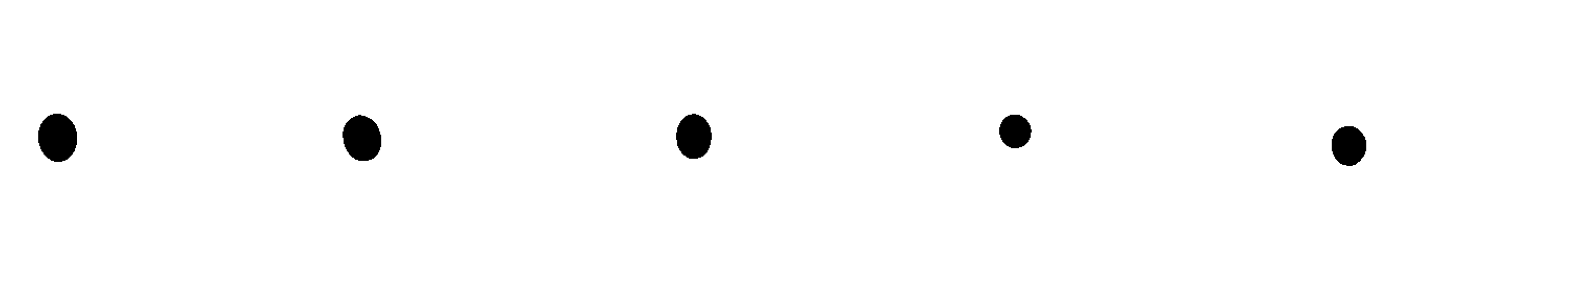

In [7]:
'''STEP-5 : After Pre-processing Displaying Images'''
import matplotlib.pyplot as plt

# Display a few preprocessed masks
def display_grayscale_masks(masks, num_images=5):
    """Displays a specified number of preprocessed grayscale masks.

    Args:
        masks: NumPy array of preprocessed masks.
        num_images: Number of masks to display.
    """
    fig, axes = plt.subplots(1, num_images, figsize=(20, 4))  # Create a figure and subplots
    for i in range(num_images):
        axes[i].imshow(masks[i].squeeze(), cmap='gray')  # Display mask as grayscale
        axes[i].axis('off')  # Turn off axis labels and ticks
    plt.show()

# Display 5 preprocessed masks
display_grayscale_masks(train_masks, num_images=5)


In [8]:
'''STEP-6 : Fitting the Model'''
 # Split into training and validation sets
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(train_images, train_masks, test_size=0.2, random_state=42)

# Previous code
model = unet_model()
# Use X_val and y_val (created in train_test_split) instead of val_images and val_masks
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=16)

Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1665s 83s/step - accuracy: 0.8437 - loss: 0.3512 - val_accuracy: 0.9832 - val_loss: 0.0832
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1647s 81s/step - accuracy: 0.9829 - loss: 0.0758 - val_accuracy: 0.9832 - val_loss: 0.0636
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1647s 81s/step - accuracy: 0.9829 - loss: 0.0623 - val_accuracy: 0.9832 - val_loss: 0.0658
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1625s 80s/step - accuracy: 0.9828 - loss: 0.0598 - val_accuracy: 0.9832 - val_loss: 0.0585
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1669s 81s/step - accuracy: 0.9829 - loss: 0.0602 - val_accuracy: 0.9832 - val_loss: 0.0566
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1610s 80s/step - accuracy: 0.9828 - loss: 0.0574 - val_accuracy: 0.9832 - val_loss: 0.0549
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1665s 81s/step - accuracy: 0.9828 - loss: 0.0528 - val_accuracy: 0.9832 - val_loss: 0.0541
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1660s 82s/step - accuracy: 0.9830 - loss: 0.0527 - val_accu

3/3 ━━━━━━━━━━━━━━━━━━━━ 110s 32s/step


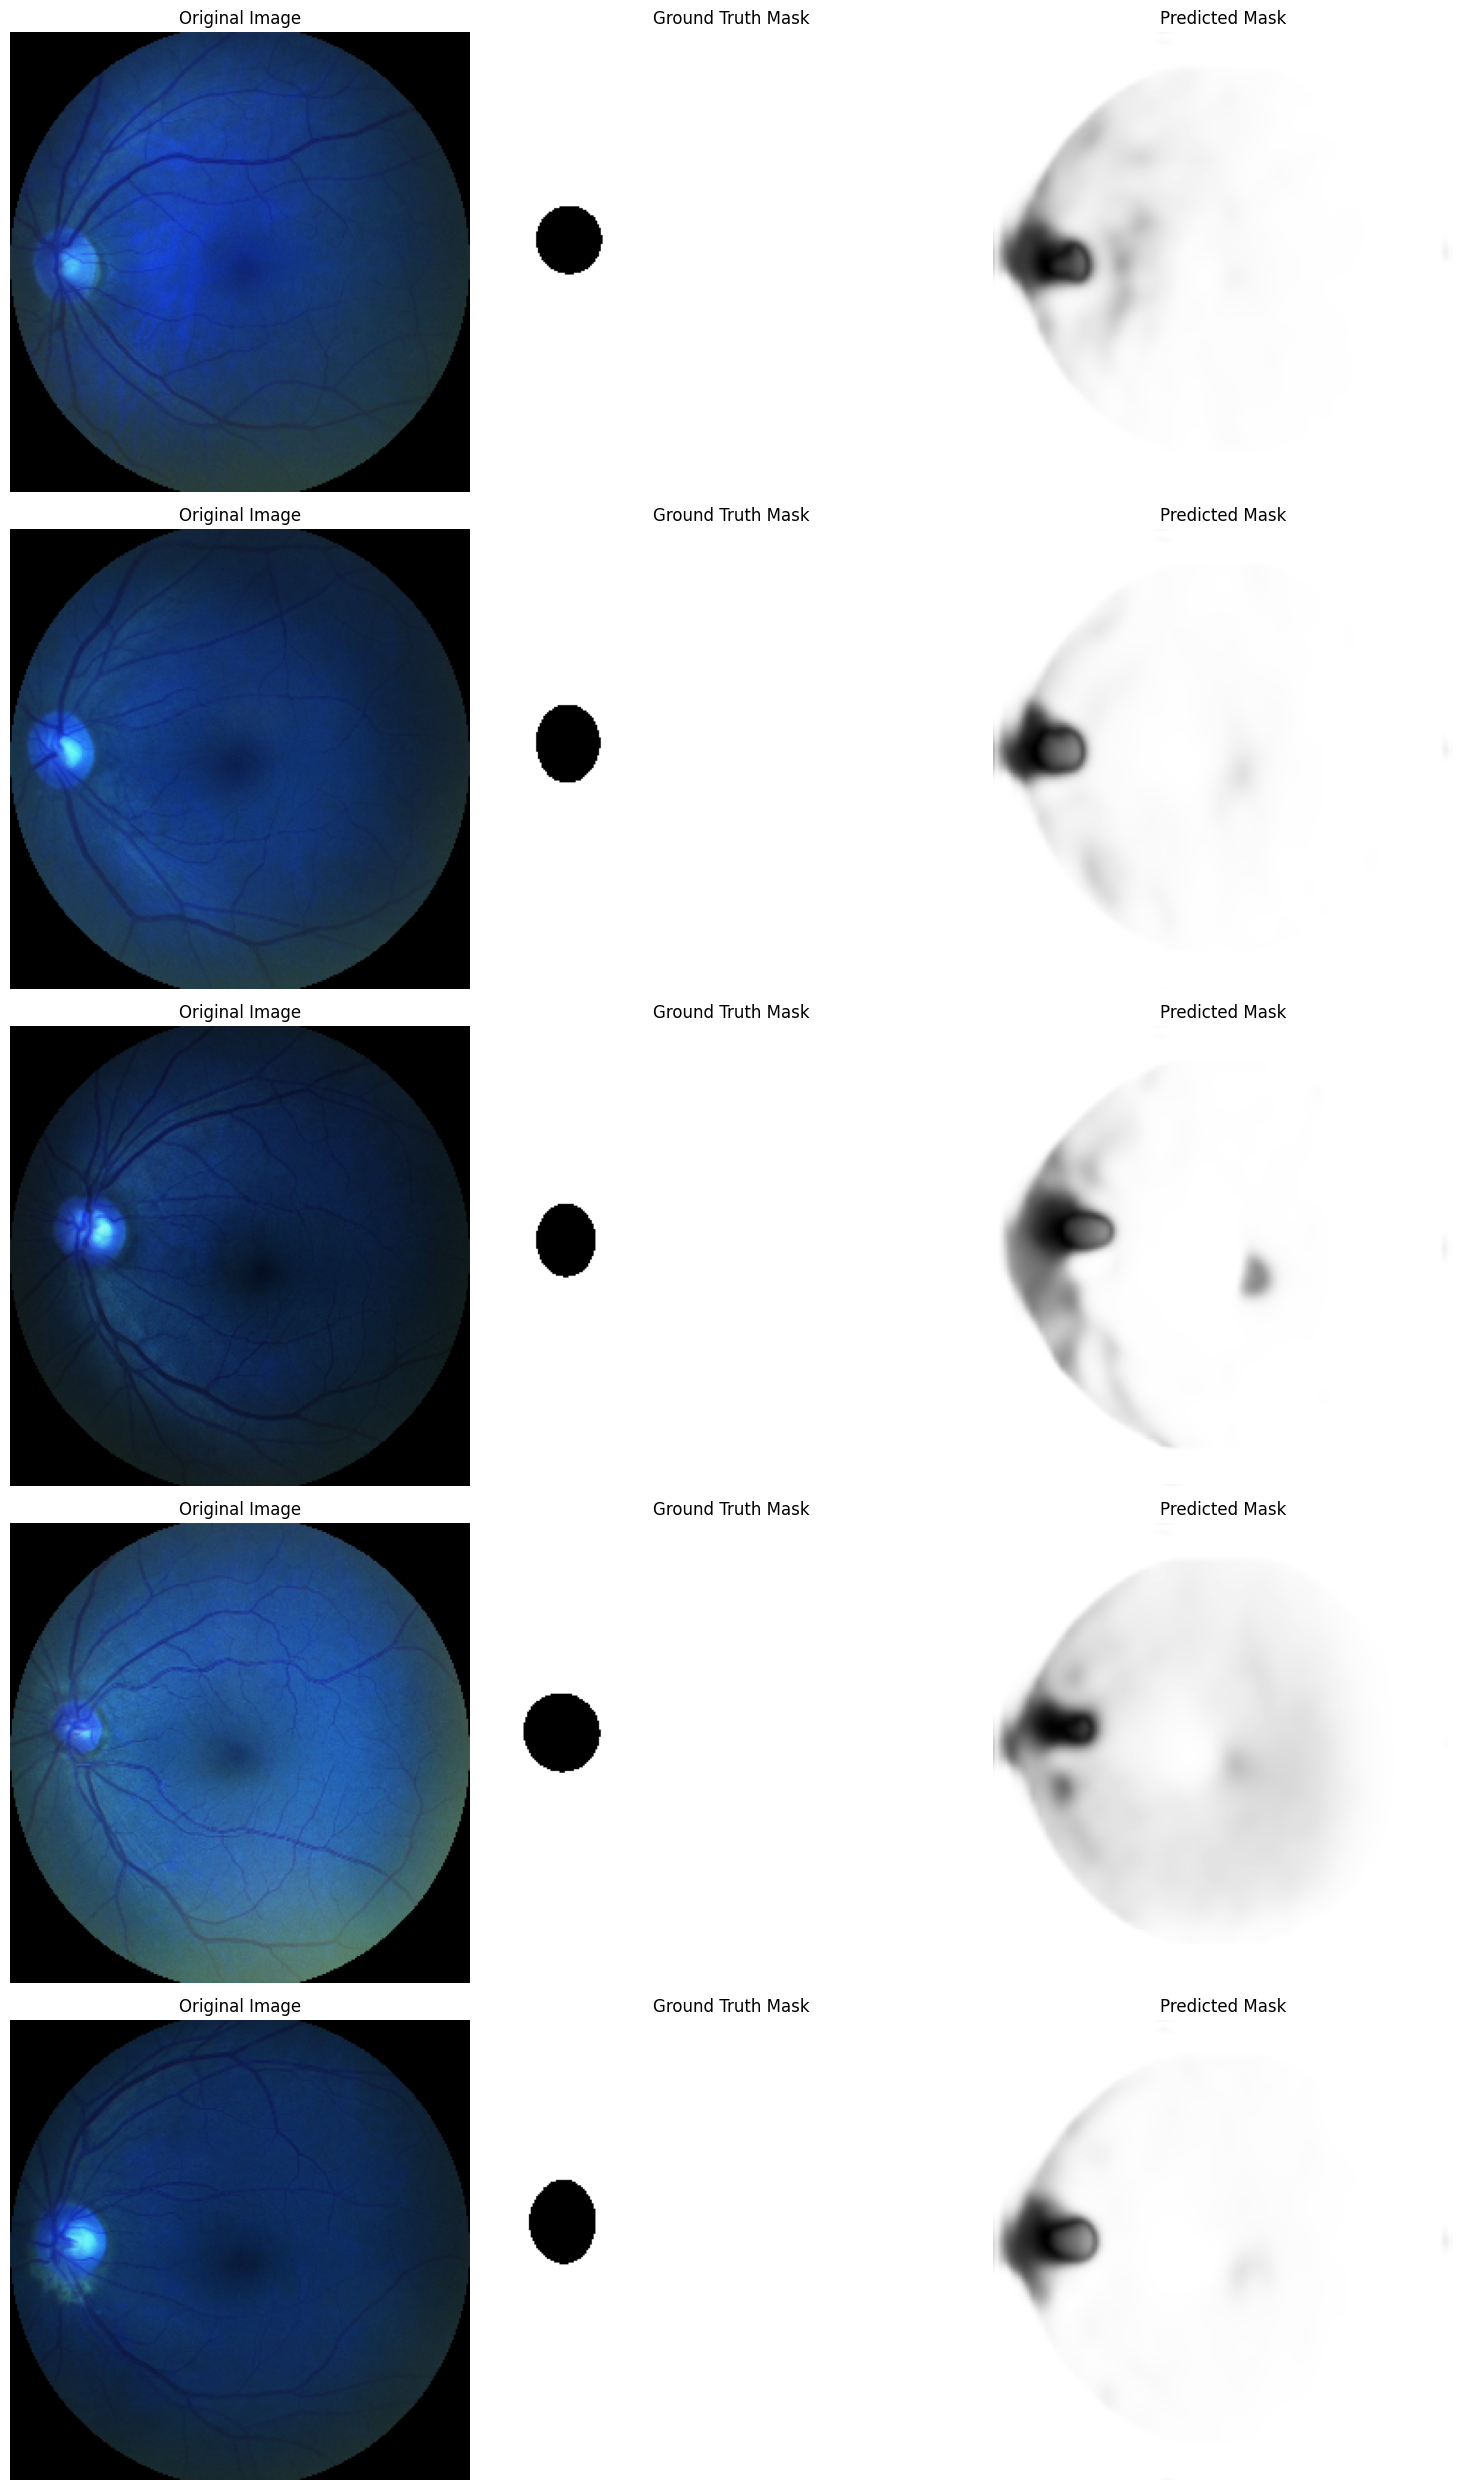

In [9]:
'''Dispaly Results'''
import matplotlib.pyplot as plt

def display_results(images, masks, predicted_masks, num_images=5):
    """Displays original images, ground truth masks, and predicted masks.

    Args:
        images: NumPy array of original images.
        masks: NumPy array of ground truth masks.
        predicted_masks: NumPy array of predicted masks.
        num_images: Number of images to display.
    """
    fig, axes = plt.subplots(num_images, 3, figsize=(15, num_images * 5))

    for i in range(num_images):
        # Original Image
        axes[i, 0].imshow(images[i])
        axes[i, 0].set_title('Original Image')
        axes[i, 0].axis('off')

        # Ground Truth Mask
        axes[i, 1].imshow(masks[i].squeeze(), cmap='gray')  # Squeeze to remove channel dimension
        axes[i, 1].set_title('Ground Truth Mask')
        axes[i, 1].axis('off')

        # Predicted Mask
        axes[i, 2].imshow(predicted_masks[i].squeeze(), cmap='gray')  # Squeeze to remove channel dimension
        axes[i, 2].set_title('Predicted Mask')
        axes[i, 2].axis('off')


    plt.tight_layout()
    plt.show()

# Make predictions on the validation set
predicted_masks = model.predict(X_val)

# Display results for a few images from the validation set
display_results(X_val, y_val, predicted_masks)

In [ ]:
import matplotlib.pyplot as plt
test_images_path = '/content/drive/MyDrive/REFUGE2/test/images'
test_images = load_images_from_folder(test_images_path)
test_images = test_images / 255.0

# Predicting the segmentation masks using the trained model
predicted_masks = model.predict(test_images)

# Display a few test images and their corresponding predicted masks
num_images_to_show = 5
for i in range(num_images_to_show):
    plt.figure(figsize=(10, 4))

    # Original test image
    plt.subplot(1, 2, 1)
    plt.imshow(test_images[i])
    plt.title('Test Image')

    # Segmented mask
    plt.subplot(1, 2, 2)
    plt.imshow(predicted_masks[i].squeeze(), cmap='gray')
    plt.title('Predicted Mask')

    plt.show()


 2/13 ━━━━━━━━━━━━━━━━━━━━ 8:16 45s/step 

In [10]:
# '''STEP-7 : Classification'''
# import numpy as np
# import cv2
# import os

# # Function to calculate area of a mask (assuming binary mask where 1 is the region of interest)
# def calculate_area(mask):
#     return np.sum(mask > 0)  # Count the number of non-zero pixels in the binary mask

# # Function to calculate Cup-to-Disc Ratio (CDR)
# def calculate_cdr(disc_mask, cup_mask):
#     disc_area = calculate_area(disc_mask)
#     cup_area = calculate_area(cup_mask)

#     if disc_area == 0:
#         return 0  # To avoid division by zero

#     cdr = cup_area / disc_area
#     return cdr

# # Function to classify glaucoma based on CDR threshold
# def classify_glaucoma(cdr, threshold=0.6):
#     if cdr >= threshold:
#         return "Glaucoma Detected"
#     else:
#         return "Normal"

# # Example usage
# disc_mask = cv2.imread('disc_mask.png', cv2.IMREAD_GRAYSCALE)  # Load the segmented disc mask
# cup_mask = cv2.imread('cup_mask.png', cv2.IMREAD_GRAYSCALE)    # Load the segmented cup mask

# cdr = calculate_cdr(disc_mask, cup_mask)
# classification_result = classify_glaucoma(cdr)

# print(f"Cup-to-Disc Ratio (CDR): {cdr}")
# print(f"Classification Result: {classification_result}")


TypeError: '>' not supported between instances of 'NoneType' and 'int'

In [12]:
'''STEP-7 : Classification'''
import numpy as np
import cv2
import os

# Function to calculate area of a mask (assuming binary mask where 1 is the region of interest)
def calculate_area(mask):
    return np.sum(mask > 0)  # Count the number of non-zero pixels in the binary mask

# Function to calculate Cup-to-Disc Ratio (CDR)
def calculate_cdr(disc_mask, cup_mask):
    disc_area = calculate_area(disc_mask)
    cup_area = calculate_area(cup_mask)

    if disc_area == 0:
        return 0  # To avoid division by zero

    cdr = cup_area / disc_area
    return cdr

# Function to classify glaucoma based on CDR threshold
def classify_glaucoma(cdr, threshold=0.6):
    if cdr >= threshold:
        return "Glaucoma Detected"
    else:
        return "Normal"

# Example usage
# Get the current working directory
current_directory = os.getcwd()
print(f"Current Working Directory: {current_directory}")

# Construct the full paths to the image files
disc_mask_path = os.path.join(current_directory, 'disc_mask.png')
cup_mask_path = os.path.join(current_directory, 'cup_mask.png')

# Load the segmented disc and cup masks, checking if the files exist
if os.path.exists(disc_mask_path) and os.path.exists(cup_mask_path):
    disc_mask = cv2.imread(disc_mask_path, cv2.IMREAD_GRAYSCALE)
    cup_mask = cv2.imread(cup_mask_path, cv2.IMREAD_GRAYSCALE)

    # Proceed with calculations if masks were loaded successfully
    if disc_mask is not None and cup_mask is not None:
        cdr = calculate_cdr(disc_mask, cup_mask)
        classification_result = classify_glaucoma(cdr)

        print(f"Cup-to-Disc Ratio (CDR): {cdr}")
        print(f"Classification Result: {classification_result}")
    else:
        print(f"Error: Could not load one or both mask images from: {disc_mask_path}, {cup_mask_path}")
else:
    print(f"Error: One or both mask image files not found in: {current_directory}")

Current Working Directory: /content
Error: One or both mask image files not found in: /content


In [13]:
from sklearn.tree import DecisionTreeClassifier

# Example: Extract CDR as a feature
cdr_values = calculate_cdr(segmented_masks)  # You need to define this function

# Assuming you have labels for glaucoma (1) or non-glaucoma (0)
labels = [1, 0, 0, 1, ...]  # Corresponding to each image

# Train the classifier
classifier = DecisionTreeClassifier()
classifier.fit(cdr_values, labels)

# Classify new samples
new_sample_cdr = calculate_cdr(new_segmented_mask)
prediction = classifier.predict([new_sample_cdr])


NameError: name 'segmented_masks' is not defined